# TISSUE SPECIFICITY EVALUATION PLOTS


## METANet vs Marbach

### (i) imports, parameters, functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse
import os

# pyplot parameters
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['axes.labelsize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['figure.titlesize'] = 'xx-large'
plt.rcParams['figure.labelsize'] = 'xx-large'

# MODEL PLOTTING COLOR SCHEME #
model_palette = {
    'Marbach':'tab:blue',
    'Excl. Perturbation':'tab:green',
    'Incl. LASSO':'tab:purple',
    'Excl. GENIE3':'tab:red',
    'Excl. WGCNA':'tab:orange',
    'METANets':'tab:pink',
    'ETANets':'tab:orange',
    'random permutation':'tab:gray',
    'random':'k'
}


# paths
tissues_path = "/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/tissues.txt"
eqtl_eval_path = "/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/eval_tissue_specificity/"
eqtl_path_metanet = os.path.join(eqtl_eval_path, "results_metanet_tf_binding_subregions_aggregated/")
eqtl_path_marbach = os.path.join(eqtl_eval_path, "results_marbach_tf_binding_subregions_aggregated/")

# functions
def load_eqtl(tissues, eqtl_path):
    df_list  = []
    for tissue in tissues: # network map tissue
        df = pd.read_csv(os.path.join(eqtl_path, f"{tissue}_eQTL_eval_support_and_counts.tsv"), sep="\t")
        df_list.append(df)
    return pd.concat(df_list)

def calculate_ranks(df):
    
    df['eqtl_supp_rank'] = df.groupby(['eqtl_tissue','rank'])['eqtl_supp'].rank(ascending=False, method='dense')
    df['eqtl_counts_rank'] = df.groupby(['eqtl_tissue','rank'])['eqtl_counts'].rank(ascending=False, method='dense')
    
    df = df.sort_values(by='eqtl_counts', ascending=False)
    df['eqtl_supp_rank_break_ties'] = df.groupby(['eqtl_tissue','rank'])['eqtl_supp'].rank(ascending=False, method='first')
    df = df.sort_values(by='eqtl_supp', ascending=False)
    df['eqtl_counts_rank_break_ties'] = df.groupby(['eqtl_tissue','rank'])['eqtl_counts'].rank(ascending=False, method='first')

    return df

def permutation_test(df, thresholds=[50,100,250], n_permutations=10000, seed=42):

    def _permutation_test(df, threshold, n_permutations, seed=42, eqtl_metric='supp'):

        df = df[df['rank'] == threshold]
        df = df[['eqtl_tissue','network_tissue',f'eqtl_{eqtl_metric}_rank_break_ties']]
        df = df.pivot(index=['eqtl_tissue'], columns=['network_tissue'])
        
        data = df.to_numpy()
        n = data.shape[0]
    
        # 1. observed diagonal sum
        observed_sum = np.sum(np.diag(data))
    
        # 2. generate permutations and compute sums
        rng = np.random.default_rng(42)
        perm_sums = np.zeros(n_permutations, dtype=float)
    
        for k in range(n_permutations):
            # create random permutation of column indices
            perm = rng.permutation(n)
            # sum
            perm_sum = 0
            for row in range(n):
                perm_sum += data[row, perm[row]]
            perm_sums[k] = perm_sum
    
        # 3. compute one-sided p-value
        p_value = np.mean(perm_sums <= observed_sum)
        return observed_sum, perm_sums, p_value

    dict_res = {}
    for threshold in thresholds:
        print(threshold)
        res_supp = _permutation_test(df, threshold, n_permutations, seed, eqtl_metric='supp')
        res_counts = _permutation_test(df, threshold, n_permutations, seed, eqtl_metric='counts')
        dict_res[threshold] = {}
        dict_res[threshold]['eQTL support'] = res_supp
        dict_res[threshold]['eQTL counts'] = res_counts
    return dict_res

### (ii) load data

In [2]:
# load tissues
tissues = np.loadtxt(tissues_path, dtype=str)

# load eqtl results
df_eqtl_metanet = load_eqtl(tissues, eqtl_path_metanet)
df_eqtl_marbach = load_eqtl(tissues, eqtl_path_marbach)

### (iii) evaluation result processing

#### calculate ranks

In [3]:
# calculate ranks
df_eqtl_metanet = calculate_ranks(df_eqtl_metanet)
df_eqtl_marbach = calculate_ranks(df_eqtl_marbach)

# annotate
df_eqtl_metanet['model'] = 'METANets'
df_eqtl_marbach['model'] = 'Marbach'

#### run permutation test

In [4]:
permutation_results_metanet = permutation_test(df_eqtl_metanet)
permutation_results_marbach = permutation_test(df_eqtl_marbach)

50
100
250
50
100
250


### (iv) Test -- PERMUTATION ANALYSIS 

#### empirical distribution

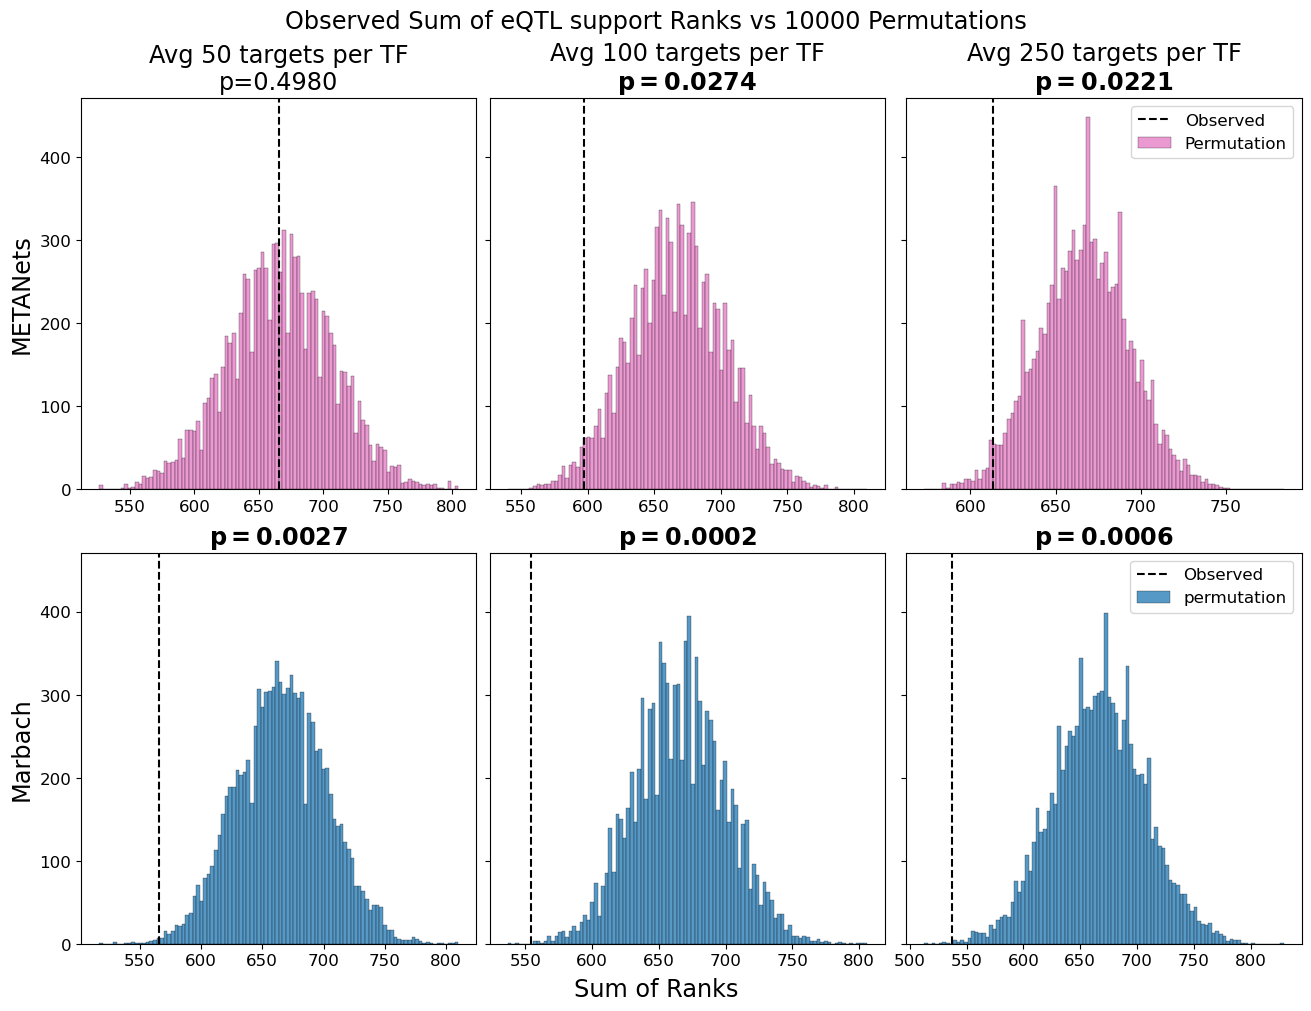

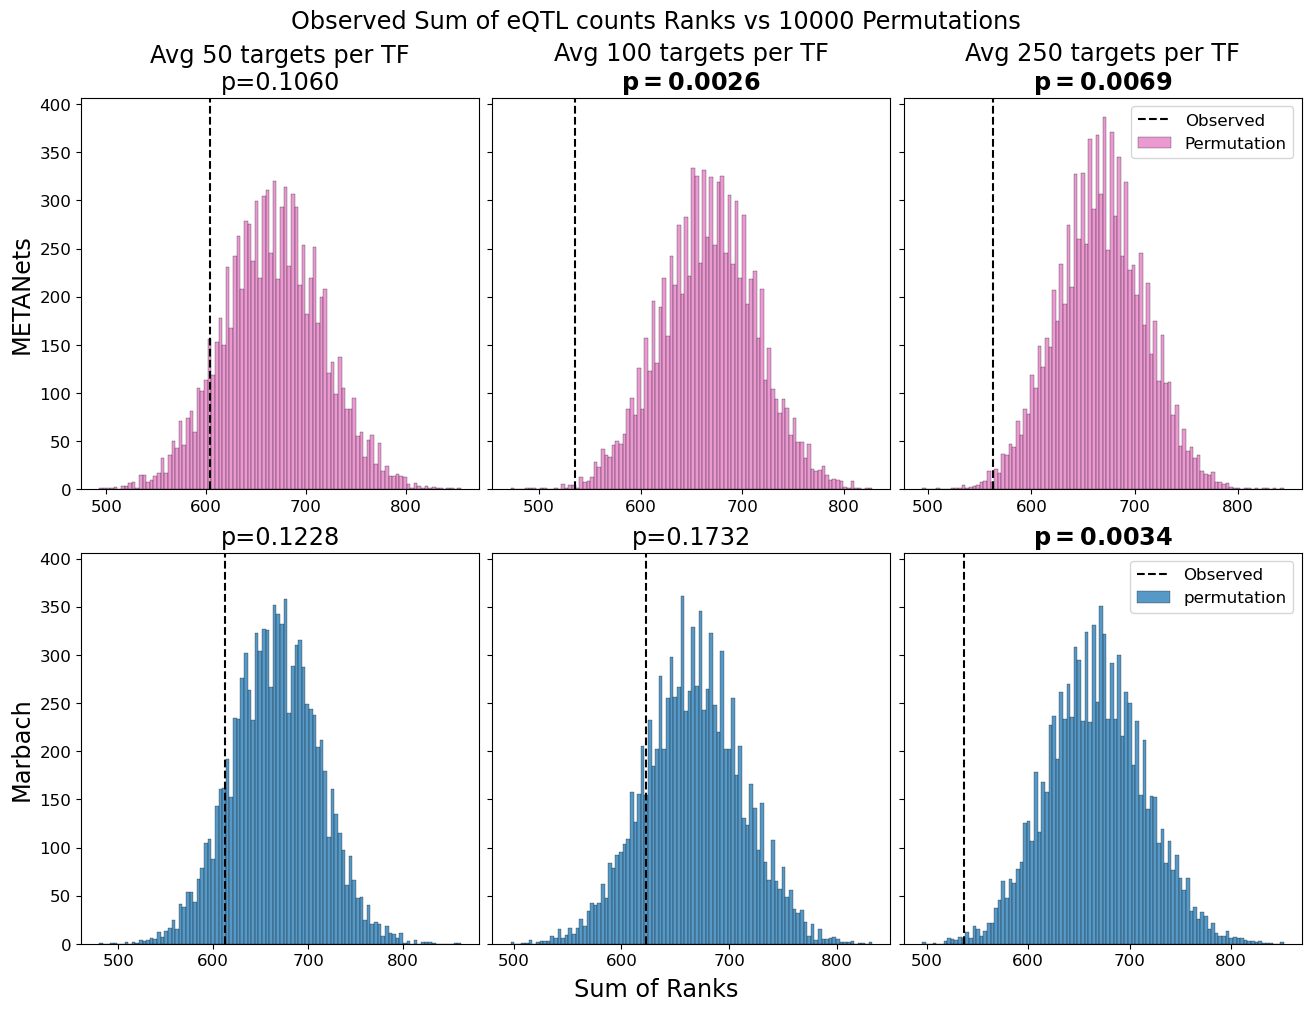

In [5]:
def plot_permutation(dict_metanet, dict_marbach, eqtl_metric='eQTL support'):
    fig, axes = plt.subplots(2,3, figsize=(13,10), sharey=True, sharex=False, constrained_layout=True)
    for i,threshold in enumerate(dict_metanet.keys()):
    
        ax_metanet = axes[0,i]
        ax_marbach = axes[1,i]
    
        obs_metanet, perm_metanet, p_metanet = dict_metanet[threshold][eqtl_metric]
        obs_marbach, perm_marbach, p_marbach = dict_marbach[threshold][eqtl_metric]

        assert len(perm_metanet) == len(perm_marbach)
        n_permutations = len(perm_metanet)
    
        sns.histplot(perm_metanet, bins=100, label='Permutation', color=model_palette['METANets'], ax=ax_metanet)
        ax_metanet.axvline(obs_metanet, color='black', linestyle='--', lw=1.5, label='Observed')
        if i == 2:
            ax_metanet.legend()
        title = f"Avg {threshold} targets per TF\n"
        if p_metanet < 0.05:
            title = title + r"$\bf{{p={:.4f}}}$".format(p_metanet)
        else:
            title = title + "p={:.4f}".format(p_metanet)
            
        ax_metanet.set_title(title)
        ax_metanet.set_ylabel("METANets")
        
        sns.histplot(perm_marbach, bins=100, label='permutation', color=model_palette['Marbach'], ax=ax_marbach)
        ax_marbach.axvline(obs_marbach, color='black', linestyle='--', lw=1.5, label='Observed')
        if i == 2:
            ax_marbach.legend()
        if p_marbach < 0.05:
            title = r"$\bf{{p={:.4f}}}$".format(p_marbach)
        else:
            title = "p={:.4f}".format(p_marbach)
        
        ax_marbach.set_title(title)
        ax_marbach.set_ylabel("Marbach")
    
    plt.suptitle(f"Observed Sum of {eqtl_metric} Ranks vs {n_permutations} Permutations")
    fig.supxlabel(f"Sum of Ranks")
    eqtl_metric_nospace = eqtl_metric.replace(' ', '_')
    plt.show()
    
plot_permutation(permutation_results_metanet, permutation_results_marbach, eqtl_metric='eQTL support')
plot_permutation(permutation_results_metanet, permutation_results_marbach, eqtl_metric='eQTL counts')


### (v) Test METANet VS Marbach

#### Wilcoxon Signed Rank Test

In [6]:
from scipy.stats import wilcoxon
import itertools

def wilcoxon_test(df_metanet, df_marbach, threshold=50, eqtl_metric='eqtl_supp'):

    df_metanet = df_metanet[df_metanet['rank'] == threshold]
    df_marbach = df_marbach[df_marbach['rank'] == threshold]

    df_metanet = df_metanet[df_metanet['eqtl_tissue'] == df_metanet['network_tissue']]
    df_marbach = df_marbach[df_marbach['eqtl_tissue'] == df_marbach['network_tissue']]

    df_metanet = df_metanet.sort_values(by='eqtl_tissue')
    df_marbach = df_marbach.sort_values(by='eqtl_tissue')

    x = df_metanet[f'{eqtl_metric}_rank_break_ties']
    y = df_marbach[f'{eqtl_metric}_rank_break_ties']

    w, p_two =  wilcoxon(x,y, method='exact', alternative='two-sided')
    
    return w, p_two

w_list = []
p_two_list = []
rank_list = []
eqtl_list = []
for threshold, eqtl_metric in itertools.product([50,100,250], ['eqtl_supp','eqtl_counts']):
    w, p_two = wilcoxon_test(df_eqtl_metanet, df_eqtl_marbach, threshold=threshold, eqtl_metric=eqtl_metric)
    rank_list.append(threshold)
    eqtl_list.append(eqtl_metric)
    w_list.append(w)
    p_two_list.append(p_two)
df_table = pd.DataFrame({'Avg targets per TF':rank_list, 'eQTL metric': eqtl_list, 'Wilcoxon w': w_list, 'Wilcoxon p (two-sided)':p_two_list})

/ref/mblab/software/conda/envs/human_tf_project/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


##### Wilcoxon W

In [7]:
df_table.pivot(columns='Avg targets per TF', index='eQTL metric', values='Wilcoxon w')

Avg targets per TF,50,100,250
eQTL metric,,,
eqtl_counts,294.0,266.5,289.0
eqtl_supp,243.0,269.5,282.0


##### P-values

In [8]:
df_table.pivot(columns='Avg targets per TF', index='eQTL metric', values='Wilcoxon p (two-sided)')

Avg targets per TF,50,100,250
eQTL metric,,,
eqtl_counts,0.952251,0.300029,0.884422
eqtl_supp,0.238075,0.844075,0.432139


## METANet vs PANDA

### (i) imports, parameters, functions

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse
import os

# pyplot parameters
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['axes.labelsize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['figure.titlesize'] = 'xx-large'
plt.rcParams['figure.labelsize'] = 'xx-large'

# MODEL PLOTTING COLOR SCHEME #
model_palette = {
    'panda_subset':'tab:cyan',
    'metanet_subset_panda':'tab:pink',
    'PANDA':'tab:cyan',
    'METANet':'tab:pink'
}


# paths
tissues_path = "/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/tissues_panda_metanet_overlap.txt"
eqtl_eval_path = "/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/eval_tissue_specificity/"
output_path = "/scratch/mblab/jungw/human_TF_project/manuscript_figures/tissue_specificity/"

# functions
def load_eqtl(tissues, eqtl_path, model):
    df_list  = []
    for tissue in tissues: # load
        df = pd.read_csv(os.path.join(eqtl_path, f"results_{model}_original_eqtl/", "final_output_per_human_network_tissue_aggregated/", f"{tissue}.tsv"), sep="\t")
        df_list.append(df)
    df = pd.concat(df_list)

    # subset for eqtl tissues
    df = df[df['eqtl_tissue'].isin(tissues)]
    # subset for network tissues
    df = df[df['network_tissue'].isin(tissues)]
    return df

def calculate_ranks(df):
    
    df['eqtl_supp_rank'] = df.groupby(['eqtl_tissue','rank'])['eqtl_supp'].rank(ascending=False, method='dense')
    df['eqtl_counts_rank'] = df.groupby(['eqtl_tissue','rank'])['eqtl_counts'].rank(ascending=False, method='dense')

    # break ties by using the other metric
    df = df.sort_values(by='eqtl_counts', ascending=False)
    df['eqtl_supp_rank_break_ties'] = df.groupby(['eqtl_tissue','rank'])['eqtl_supp'].rank(ascending=False, method='first')
    df = df.sort_values(by='eqtl_supp', ascending=False)
    df['eqtl_counts_rank_break_ties'] = df.groupby(['eqtl_tissue','rank'])['eqtl_counts'].rank(ascending=False, method='first')

    return df

def permutation_test(df, thresholds=['50','100','250','full'], n_permutations=10000, seed=42):

    def _permutation_test(df, threshold, n_permutations, seed=42, eqtl_metric='supp'):

        df = df[df['rank'] == threshold]
        df = df[['eqtl_tissue','network_tissue',f'eqtl_{eqtl_metric}_rank_break_ties']]
        df = df.pivot(index=['eqtl_tissue'], columns=['network_tissue'])
        
        data = df.to_numpy()
        n = data.shape[0]
    
        # 1. observed diagonal sum
        observed_sum = np.sum(np.diag(data))
    
        # 2. generate permutations and compute sums
        rng = np.random.default_rng(42)
        perm_sums = np.zeros(n_permutations, dtype=float)
    
        for k in range(n_permutations):
            # create random permutation of column indices
            perm = rng.permutation(n)
            # sum
            perm_sum = 0
            for row in range(n):
                perm_sum += data[row, perm[row]]
            perm_sums[k] = perm_sum
    
        # 3. compute one-sided p-value
        p_value = np.mean(perm_sums <= observed_sum)
        return observed_sum, perm_sums, p_value

    dict_res = {}
    for threshold in thresholds:
        print(threshold)
        res_supp = _permutation_test(df, threshold, n_permutations, seed, eqtl_metric='supp')
        res_counts = _permutation_test(df, threshold, n_permutations, seed, eqtl_metric='counts')
        dict_res[threshold] = {}
        dict_res[threshold]['eQTL support'] = res_supp
        dict_res[threshold]['eQTL counts'] = res_counts
    return dict_res

### (ii) load data

In [10]:
# load tissues
tissues = np.loadtxt(tissues_path, dtype=str)

# load eqtl results
df_metanet = load_eqtl(tissues, eqtl_eval_path, 'metanet_subset_panda')
df_panda = load_eqtl(tissues, eqtl_eval_path, 'panda_subset')

### (iii) evaluation result processing

#### calculate ranks

In [23]:
# calculate ranks
df_metanet = calculate_ranks(df_metanet)
df_panda = calculate_ranks(df_panda)

# annotate
df_metanet['model'] = 'METANet'
df_panda['model'] = 'PANDA'

#### run permutation test

In [24]:
df_metanet_permutation = permutation_test(df_metanet, thresholds=['50','100','250'])#,'full'])
df_panda_permutation = permutation_test(df_panda, thresholds=['50','100','250'])#,'full'])

50
100
250
50
100
250


In [25]:
df_metanet_permutation

{'50': {'eQTL support': (333.0,
   array([361., 342., 353., ..., 327., 332., 380.]),
   0.2411),
  'eQTL counts': (335.0,
   array([334., 354., 346., ..., 323., 361., 401.]),
   0.2968)},
 '100': {'eQTL support': (320.0,
   array([359., 334., 368., ..., 320., 344., 356.]),
   0.0964),
  'eQTL counts': (284.0,
   array([330., 351., 367., ..., 317., 302., 397.]),
   0.0066)},
 '250': {'eQTL support': (331.0,
   array([366., 337., 354., ..., 344., 347., 374.]),
   0.1426),
  'eQTL counts': (324.0,
   array([393., 358., 377., ..., 324., 327., 383.]),
   0.1289)}}

In [26]:
df_panda_permutation

{'50': {'eQTL support': (319.0,
   array([337., 356., 347., ..., 382., 356., 353.]),
   0.0905),
  'eQTL counts': (329.0,
   array([340., 350., 334., ..., 357., 314., 375.]),
   0.2024)},
 '100': {'eQTL support': (330.0,
   array([343., 352., 338., ..., 362., 353., 337.]),
   0.1757),
  'eQTL counts': (331.0,
   array([329., 359., 347., ..., 361., 384., 351.]),
   0.2452)},
 '250': {'eQTL support': (346.0,
   array([369., 324., 355., ..., 411., 331., 349.]),
   0.4244),
  'eQTL counts': (328.0,
   array([377., 315., 370., ..., 391., 350., 356.]),
   0.1834)}}

In [27]:
def calculate_closed_form_solution(df, rank='50', metric='eqtl_supp'):

    # calculates number of ways to achieve sum 's' using 'n' dice with 'k' faces each
    def count_sum_ways(s, n, k):
        import math
        
        total_ways = 0
    
        # The loop implements the summation part of the formula
        # j is the number of dice assumed to violate the upper bound k
        limit = (s - n) // k
        for j in range(limit + 1):
            
            # Calculate each part of the term in the summation
            sign = (-1)**j
            term1 = math.comb(n, j)
            
            # The top part of the second combination term
            comb_top = s - (k * j) - 1
            comb_bottom = n - 1
            
            # math.comb handles the case where comb_top < comb_bottom by returning 0
            term2 = math.comb(comb_top, comb_bottom)
            
            # Add the calculated term to the total
            total_ways += sign * term1 * term2
            
        return total_ways
    
    df = df[df['rank'] == rank]
    df = df[df['eqtl_tissue'] == df['network_tissue']]

    metric_col = df[f"{metric}_rank_break_ties"]
    # metric_col = df[f"{metric}_rank"]
    observed_sum = int(np.sum(metric_col))

    # print(f"observed sum: {observed_sum}")

    n = 26 # num dice
    k = 26 # num faces per die

    sample_space = k**n # number of possible outcomes
    min_possible_sum = n # smallest possible sum is all ranks = 1

    # sum probabilities of achieving minimum possible sum to observed sum
    favorable_outcomes = 0
    for s in range(min_possible_sum, observed_sum+1):
        favorable_outcomes += count_sum_ways(s, n, k)

    # p-value is the ratio of favorable to total outcomes
    p_val = favorable_outcomes / sample_space

    # print(p_val)

    return p_val

df_row = []
for rank in ['50','100','250']:
    for metric in ['eqtl_supp','eqtl_counts']:
        p = calculate_closed_form_solution(df_metanet, rank=rank, metric=metric)
        df_row.append({
            'rank':rank,
            'metric':metric,
            'p-value':p
        })
df_metanet_p = pd.DataFrame(df_row)
df_metanet_p['model'] = 'metanet'

df_row = []
for rank in ['50','100','250']:
    for metric in ['eqtl_supp','eqtl_counts']:
        p = calculate_closed_form_solution(df_panda, rank=rank, metric=metric)
        df_row.append({
            'rank':rank,
            'metric':metric,
            'p-value':p
        })
df_panda_p = pd.DataFrame(df_row)
df_panda_p['model'] = 'panda'

df_p = pd.concat([df_metanet_p, df_panda_p])
df_p


,rank,metric,p-value,model
0,50,eqtl_supp,0.324503,metanet
1,50,eqtl_counts,0.343440,metanet
2,100,eqtl_supp,0.213628,metanet
3,100,eqtl_counts,0.041016,metanet
4,250,eqtl_supp,0.306004,metanet
5,250,eqtl_counts,0.245231,metanet
0,50,eqtl_supp,0.206110,panda
1,50,eqtl_counts,0.287982,panda
2,100,eqtl_supp,0.296931,panda
3,100,eqtl_counts,0.306004,panda


In [28]:
list_p_metanet_supp, list_p_panda_supp, list_p_metanet_counts, list_p_panda_counts = [], [], [], []

df_metanet_int = df_metanet[df_metanet['rank'] != 'full']
df_metanet_int['rank'] = df_metanet_int['rank'].astype(int)
df_panda_int = df_panda[df_panda['rank'] != 'full']
df_panda_int['rank'] = df_panda_int['rank'].astype(int)

for rank in range(1,251):
    print(rank)
    list_p_metanet_supp.append(calculate_closed_form_solution(df_metanet_int, rank=rank, metric='eqtl_supp'))
    list_p_panda_supp.append(calculate_closed_form_solution(df_panda_int, rank=rank, metric='eqtl_supp'))
    
    list_p_metanet_counts.append(calculate_closed_form_solution(df_metanet_int, rank=rank, metric='eqtl_counts'))
    list_p_panda_counts.append(calculate_closed_form_solution(df_panda_int, rank=rank, metric='eqtl_counts'))
 

/tmp/ipykernel_825492/1248779705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metanet_int['rank'] = df_metanet_int['rank'].astype(int)
/tmp/ipykernel_825492/1248779705.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panda_int['rank'] = df_panda_int['rank'].astype(int)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


In [17]:
sns.lineplot(x=np.arange(1,251), y=list_p_metanet_supp, label='metanet')
sns.lineplot(x=np.arange(1,251), y=list_p_panda_supp, label='panda')
plt.axhline(0.05, color='red', linestyle=':')
plt.title("closed form solution p-values (26 tissues)\neQTL support")

Text(0.5, 1.0, 'closed form solution p-values (26 tissues)\neQTL support')

In [18]:
sns.lineplot(x=np.arange(1,251), y=list_p_metanet_counts, label='metanet')
sns.lineplot(x=np.arange(1,251), y=list_p_panda_counts, label='panda')
plt.axhline(0.05, color='red', linestyle=':')
plt.title("closed form solution p-values (26 tissues)\neQTL counts")

Text(0.5, 1.0, 'closed form solution p-values (26 tissues)\neQTL counts')

### (iv) PLOT -- PERMUTATION ANALYSIS 

#### empirical distribution

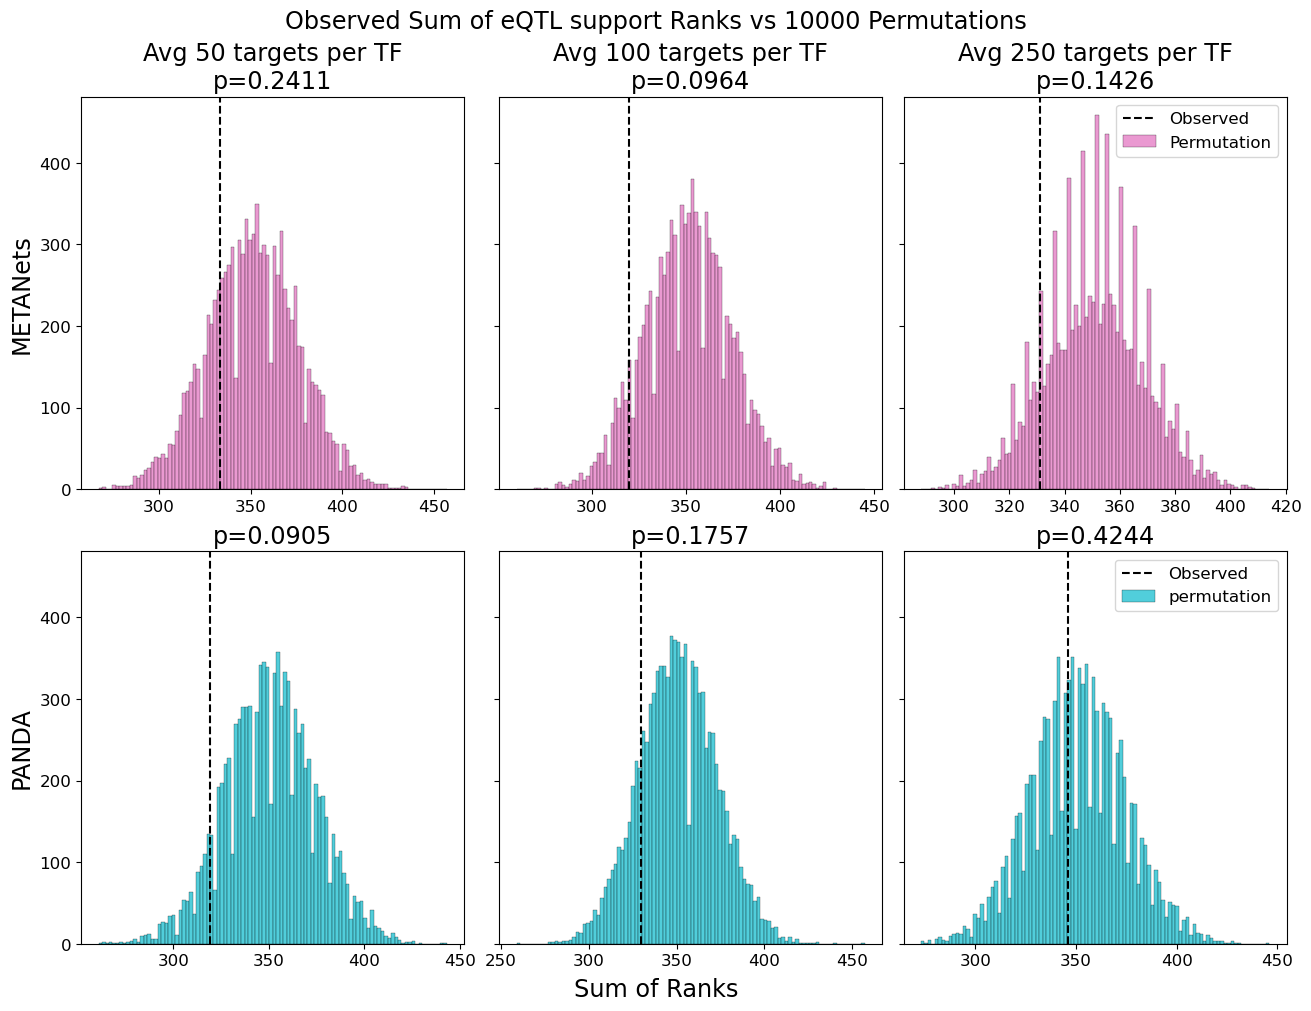

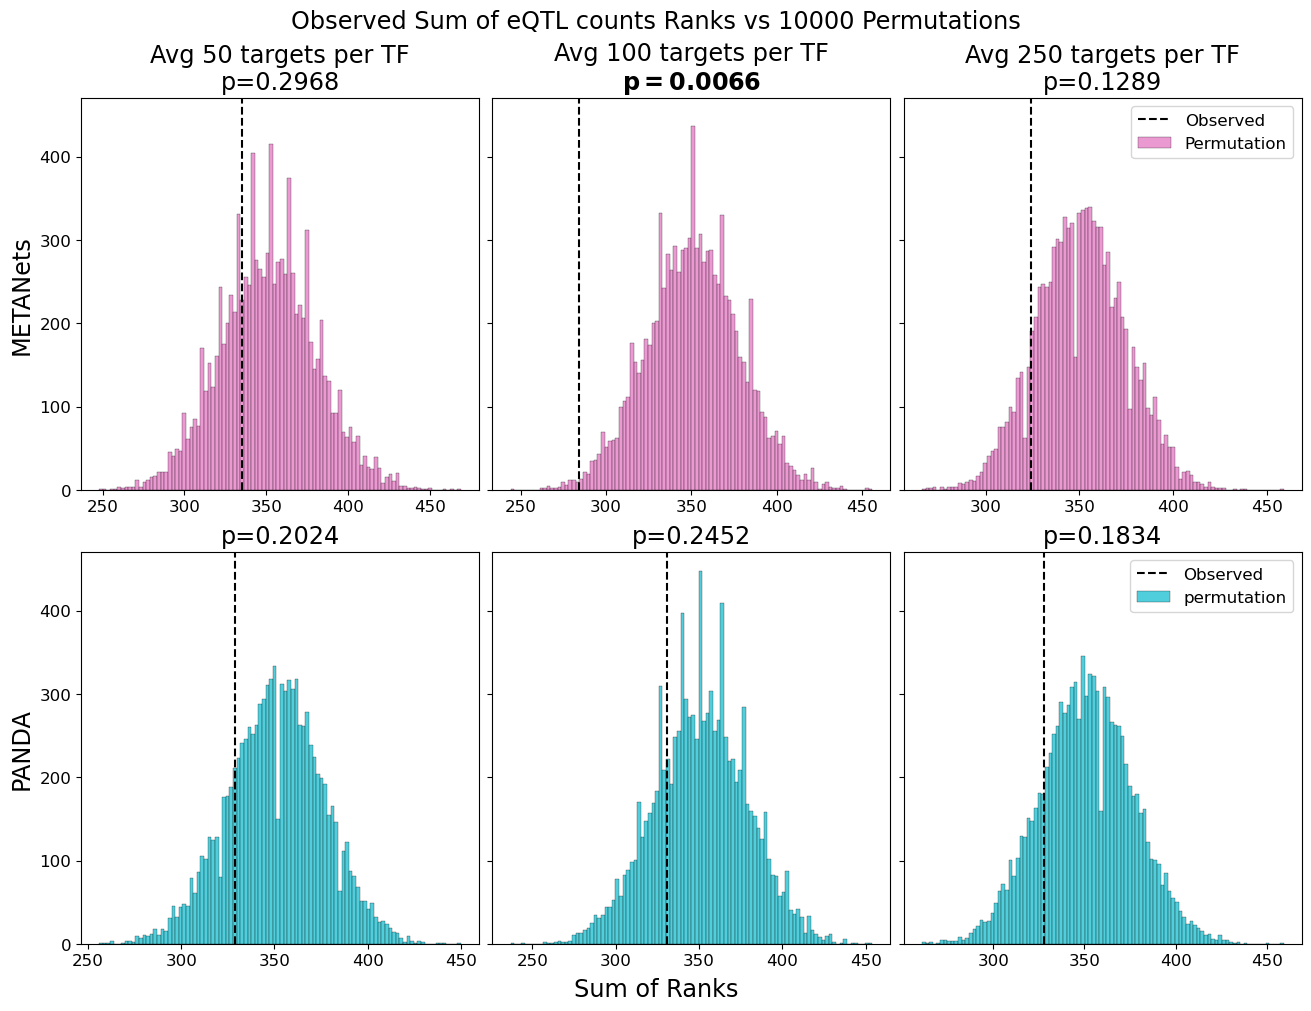

In [29]:
def plot_permutation(dict_metanet, dict_panda, eqtl_metric='eQTL support'):
    fig, axes = plt.subplots(2,3, figsize=(13,10), sharey=True, sharex=False, constrained_layout=True)
    for i,threshold in enumerate(dict_metanet.keys()):
    
        ax_final = axes[0,i]
        ax_marbach = axes[1,i]
    
        obs_final, perm_final, p_final = dict_metanet[threshold][eqtl_metric]
        obs_marbach, perm_marbach, p_marbach = dict_panda[threshold][eqtl_metric]

        assert len(perm_final) == len(perm_marbach)
        n_permutations = len(perm_final)
    
        sns.histplot(perm_final, bins=100, label='Permutation', color=model_palette['METANet'], ax=ax_final)
        ax_final.axvline(obs_final, color='black', linestyle='--', lw=1.5, label='Observed')
        if i == 2:
            ax_final.legend()
        title = f"Avg {threshold} targets per TF\n"
        if p_final < 0.05:
            title = title + r"$\bf{{p={:.4f}}}$".format(p_final)
        else:
            title = title + "p={:.4f}".format(p_final)
            
        ax_final.set_title(title)
        ax_final.set_ylabel("METANets")
        
        sns.histplot(perm_marbach, bins=100, label='permutation', color=model_palette['PANDA'], ax=ax_marbach)
        ax_marbach.axvline(obs_marbach, color='black', linestyle='--', lw=1.5, label='Observed')
        if i == 2:
            ax_marbach.legend()
        if p_marbach < 0.05:
            title = r"$\bf{{p={:.4f}}}$".format(p_marbach)
        else:
            title = "p={:.4f}".format(p_marbach)
        
        ax_marbach.set_title(title)
        ax_marbach.set_ylabel("PANDA")
    
    plt.suptitle(f"Observed Sum of {eqtl_metric} Ranks vs {n_permutations} Permutations")
    fig.supxlabel(f"Sum of Ranks")
    eqtl_metric_nospace = eqtl_metric.replace(' ', '_')
    plt.show()
    
plot_permutation(df_metanet_permutation, df_panda_permutation, eqtl_metric='eQTL support')
plot_permutation(df_metanet_permutation, df_panda_permutation, eqtl_metric='eQTL counts')


### (v) PLOT -- METANETS VS PANDA

#### Wilcoxon Signed Rank Test

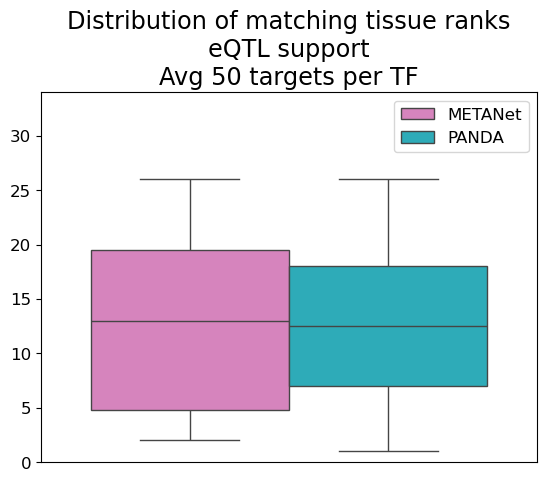

median difference: 2.5
# tissues METANet better: 11
# tissues same: 0
# tissues METANet worse: 15


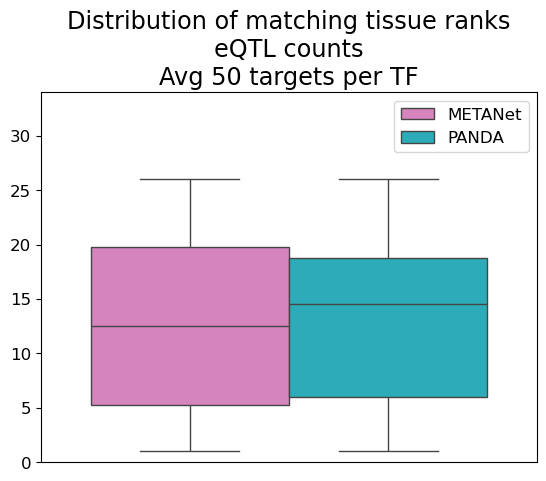

/ref/mblab/software/conda/envs/human_tf_project/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


median difference: 1.5
# tissues METANet better: 11
# tissues same: 2
# tissues METANet worse: 13


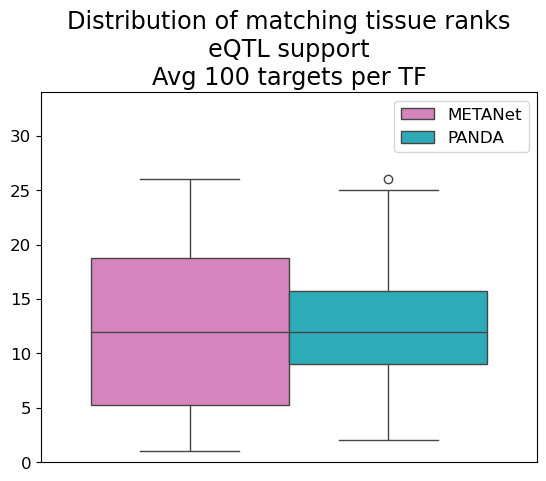

/ref/mblab/software/conda/envs/human_tf_project/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


median difference: -1.0
# tissues METANet better: 15
# tissues same: 1
# tissues METANet worse: 10


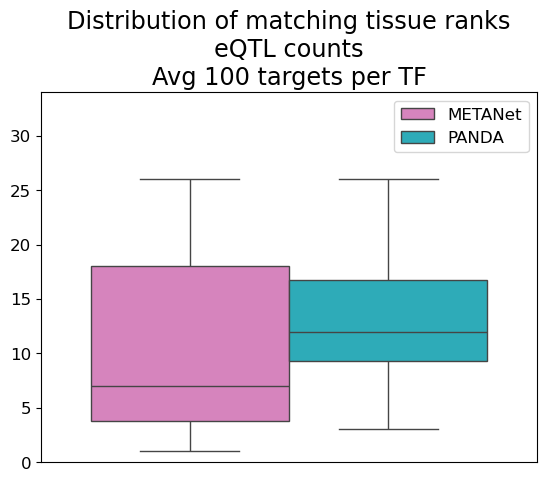

/ref/mblab/software/conda/envs/human_tf_project/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


median difference: -3.0
# tissues METANet better: 14
# tissues same: 1
# tissues METANet worse: 11


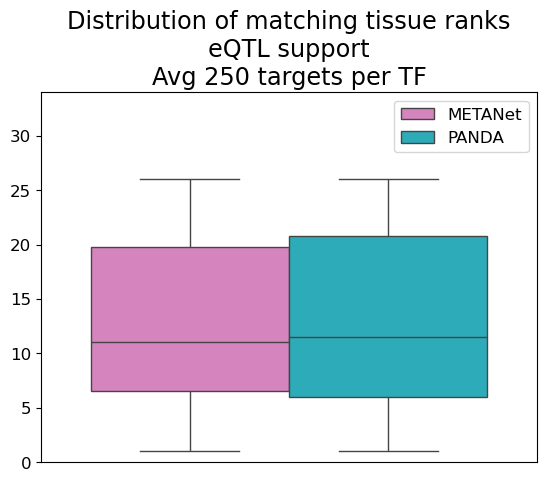

/ref/mblab/software/conda/envs/human_tf_project/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


median difference: -1.0
# tissues METANet better: 13
# tissues same: 1
# tissues METANet worse: 12


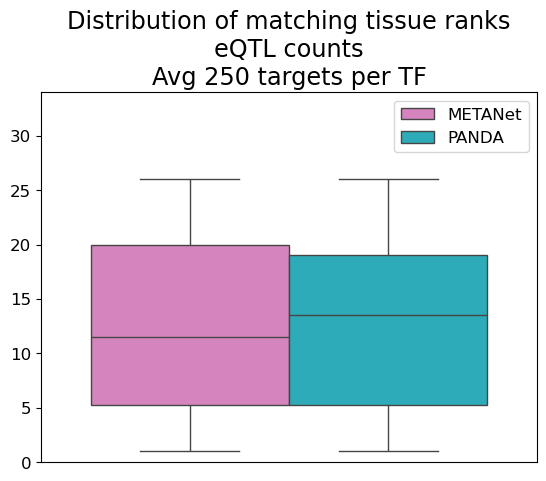

/ref/mblab/software/conda/envs/human_tf_project/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


median difference: 0.5
# tissues METANet better: 11
# tissues same: 2
# tissues METANet worse: 13


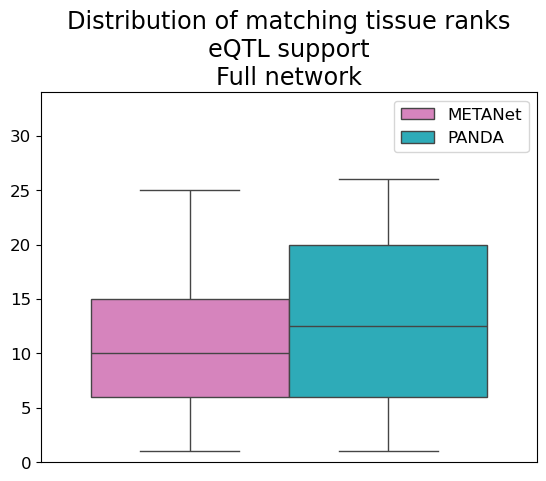

/ref/mblab/software/conda/envs/human_tf_project/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


median difference: -1.0
# tissues METANet better: 16
# tissues same: 3
# tissues METANet worse: 7


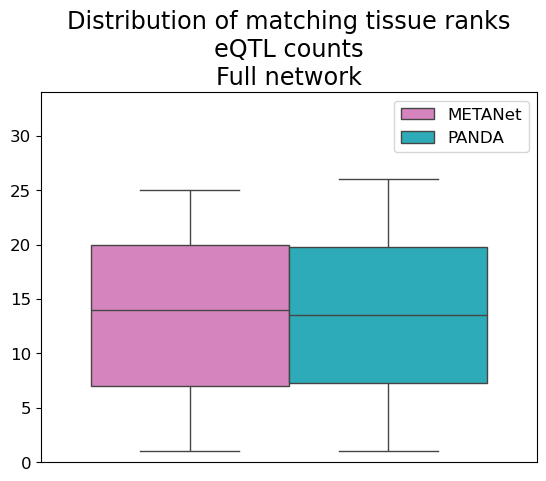

median difference: -1.0
# tissues METANet better: 15
# tissues same: 4
# tissues METANet worse: 7


/ref/mblab/software/conda/envs/human_tf_project/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


,Avg targets per TF,eQTL metric,Wilcoxon w,Wilcoxon p (two-sided)
0,50,eqtl_supp,152.0,0.565132
1,50,eqtl_counts,145.5,0.897655
2,100,eqtl_supp,152.0,0.777327
3,100,eqtl_counts,132.0,0.411458
4,250,eqtl_supp,156.5,0.871648
5,250,eqtl_counts,144.5,0.875012
6,full,eqtl_supp,97.0,0.211784
7,full,eqtl_counts,101.0,0.405005


In [30]:
from scipy.stats import wilcoxon
import itertools

def wilcoxon_test(df_final, df_panda, threshold='full', eqtl_metric='eqtl_supp'):

    df_final = df_final[df_final['rank'] == threshold]
    df_panda = df_panda[df_panda['rank'] == threshold]

    df_final = df_final[df_final['eqtl_tissue'] == df_final['network_tissue']]
    df_panda = df_panda[df_panda['eqtl_tissue'] == df_panda['network_tissue']]

    df_final = df_final.sort_values(by='eqtl_tissue')
    df_panda = df_panda.sort_values(by='eqtl_tissue')

    x = df_final[f'{eqtl_metric}_rank_break_ties']
    y = df_panda[f'{eqtl_metric}_rank_break_ties']

    eqtl_metric_dict = {
        'eqtl_supp':'eQTL support',
        'eqtl_counts':'eQTL counts'
    }
    eqtl_metric_title = eqtl_metric_dict[eqtl_metric]

    df_plot = pd.concat([df_final, df_panda])
    sns.boxplot(df_plot, x='rank', y=f'{eqtl_metric}_rank_break_ties', hue='model', palette=model_palette)
    plt.title(f"Distribution of matching tissue ranks\n{eqtl_metric_title}\nAvg {threshold} targets per TF")
    if threshold == 'full': 
        plt.title(f"Distribution of matching tissue ranks\n{eqtl_metric_title}\nFull network")
    plt.ylim(0,34)
    plt.legend(loc=0)
    plt.ylabel(None)
    plt.xlabel(None)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False # labels along the bottom edge are off
    )
    plt.show()

    w, p_two =  wilcoxon(x,y, method='exact', alternative='two-sided')
    diff = np.array(x) - np.array(y)
    # print(diff)
    print(f"median difference: {np.median(diff)}")
    print(f"# tissues METANet better: {sum(diff < 0)}")
    print(f"# tissues same: {sum(diff == 0)}")
    print(f"# tissues METANet worse: {sum(diff > 0)}")
    
    return w, p_two

w_list = []
p_two_list = []
rank_list = []
eqtl_list = []
for threshold, eqtl_metric in itertools.product(['50','100','250','full'], ['eqtl_supp','eqtl_counts']):
    w, p_two = wilcoxon_test(df_metanet, df_panda, threshold=threshold, eqtl_metric=eqtl_metric)
    rank_list.append(threshold)
    eqtl_list.append(eqtl_metric)
    w_list.append(w)
    p_two_list.append(p_two)
df_table = pd.DataFrame({'Avg targets per TF':rank_list, 'eQTL metric': eqtl_list, 'Wilcoxon w': w_list, 'Wilcoxon p (two-sided)':p_two_list})
df_table

## Tissue-specific METANet vs Tissue-specific PANDA

### (i) imports, parameters, functions

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse
import os

# pyplot parameters
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['axes.labelsize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['figure.titlesize'] = 'xx-large'
plt.rcParams['figure.labelsize'] = 'xx-large'

# MODEL PLOTTING COLOR SCHEME #
model_palette = {
    'panda_tissue_specific':'tab:cyan',
    'metanet_tissue_specific':'tab:pink',
    'tissue-specific PANDA':'tab:cyan',
    'tissue-specific METANets':'tab:pink'
}

# paths
tissues_path = "/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/tissues_panda_metanet_overlap.txt"
eqtl_eval_path = "/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/eval_tissue_specificity/"
output_path = "/scratch/mblab/jungw/human_TF_project/manuscript_figures/tissue_specificity/"

# functions
def load_eqtl(tissues, eqtl_path, model):
    df_list  = []
    for tissue in tissues: # load
        df = pd.read_csv(os.path.join(eqtl_path, f"results_{model}_original_eqtl/", "final_output_per_human_network_tissue_aggregated/", f"{tissue}.tsv"), sep="\t")
        df_list.append(df)
    df = pd.concat(df_list)

    # subset for eqtl tissues
    df = df[df['eqtl_tissue'].isin(tissues)]
    # subset for network tissues
    df = df[df['network_tissue'].isin(tissues)]
    return df

def calculate_ranks(df):
    
    df['eqtl_supp_rank'] = df.groupby(['eqtl_tissue','rank'])['eqtl_supp'].rank(ascending=False, method='dense')
    df['eqtl_counts_rank'] = df.groupby(['eqtl_tissue','rank'])['eqtl_counts'].rank(ascending=False, method='dense')

    # break ties by using the other metric
    df = df.sort_values(by='eqtl_counts', ascending=False)
    df['eqtl_supp_rank_break_ties'] = df.groupby(['eqtl_tissue','rank'])['eqtl_supp'].rank(ascending=False, method='first')
    df = df.sort_values(by='eqtl_supp', ascending=False)
    df['eqtl_counts_rank_break_ties'] = df.groupby(['eqtl_tissue','rank'])['eqtl_counts'].rank(ascending=False, method='first')

    return df

def permutation_test(df, thresholds=['50','100','250','full'], n_permutations=10000, seed=42):

    def _permutation_test(df, threshold, n_permutations, seed=42, eqtl_metric='supp'):

        df = df[df['rank'] == threshold]
        df = df[['eqtl_tissue','network_tissue',f'eqtl_{eqtl_metric}_rank_break_ties']]
        df = df.pivot(index=['eqtl_tissue'], columns=['network_tissue'])
        
        data = df.to_numpy()
        n = data.shape[0]
    
        # 1. observed diagonal sum
        observed_sum = np.sum(np.diag(data))
    
        # 2. generate permutations and compute sums
        rng = np.random.default_rng(42)
        perm_sums = np.zeros(n_permutations, dtype=float)
    
        for k in range(n_permutations):
            # create random permutation of column indices
            perm = rng.permutation(n)
            # sum
            perm_sum = 0
            for row in range(n):
                perm_sum += data[row, perm[row]]
            perm_sums[k] = perm_sum
    
        # 3. compute one-sided p-value
        p_value = np.mean(perm_sums <= observed_sum)
        return observed_sum, perm_sums, p_value

    dict_res = {}
    for threshold in thresholds:
        print(threshold)
        res_supp = _permutation_test(df, threshold, n_permutations, seed, eqtl_metric='supp')
        res_counts = _permutation_test(df, threshold, n_permutations, seed, eqtl_metric='counts')
        dict_res[threshold] = {}
        dict_res[threshold]['eQTL support'] = res_supp
        dict_res[threshold]['eQTL counts'] = res_counts
    return dict_res

### (ii) load data

In [32]:
# load tissues
tissues = np.loadtxt(tissues_path, dtype=str)

# load eqtl results
df_metanet_tissue_specific = load_eqtl(tissues, eqtl_eval_path, 'metanet_tissue_specific')
df_panda_tissue_specific = load_eqtl(tissues, eqtl_eval_path, 'panda_tissue_specific')

### (iii) evaluation result processing

#### calculate ranks

In [33]:
# calculate ranks
df_metanet_tissue_specific = calculate_ranks(df_metanet_tissue_specific)
df_panda_tissue_specific = calculate_ranks(df_panda_tissue_specific)

# annotate
df_metanet_tissue_specific['model'] = 'tissue-specific METANets'
df_panda_tissue_specific['model'] = 'tissue-specific PANDA'

#### run permutation test

In [34]:
df_metanet_tissue_specific_permutation = permutation_test(df_metanet_tissue_specific, thresholds=['full'])
df_panda_tissue_specific_permutation = permutation_test(df_panda_tissue_specific, thresholds=['full'])

full
full


In [35]:
df_metanet_tissue_specific_permutation

{'full': {'eQTL support': (307.0,
   array([398., 346., 370., ..., 361., 334., 348.]),
   0.034),
  'eQTL counts': (338.0,
   array([363., 349., 351., ..., 344., 377., 328.]),
   0.2498)}}

In [36]:
df_panda_tissue_specific_permutation

{'full': {'eQTL support': (332.0,
   array([353., 373., 349., ..., 364., 331., 369.]),
   0.2333),
  'eQTL counts': (341.0,
   array([338., 355., 361., ..., 366., 338., 359.]),
   0.1985)}}

### (iv) PLOT -- PERMUTATION ANALYSIS 

#### empirical distribution

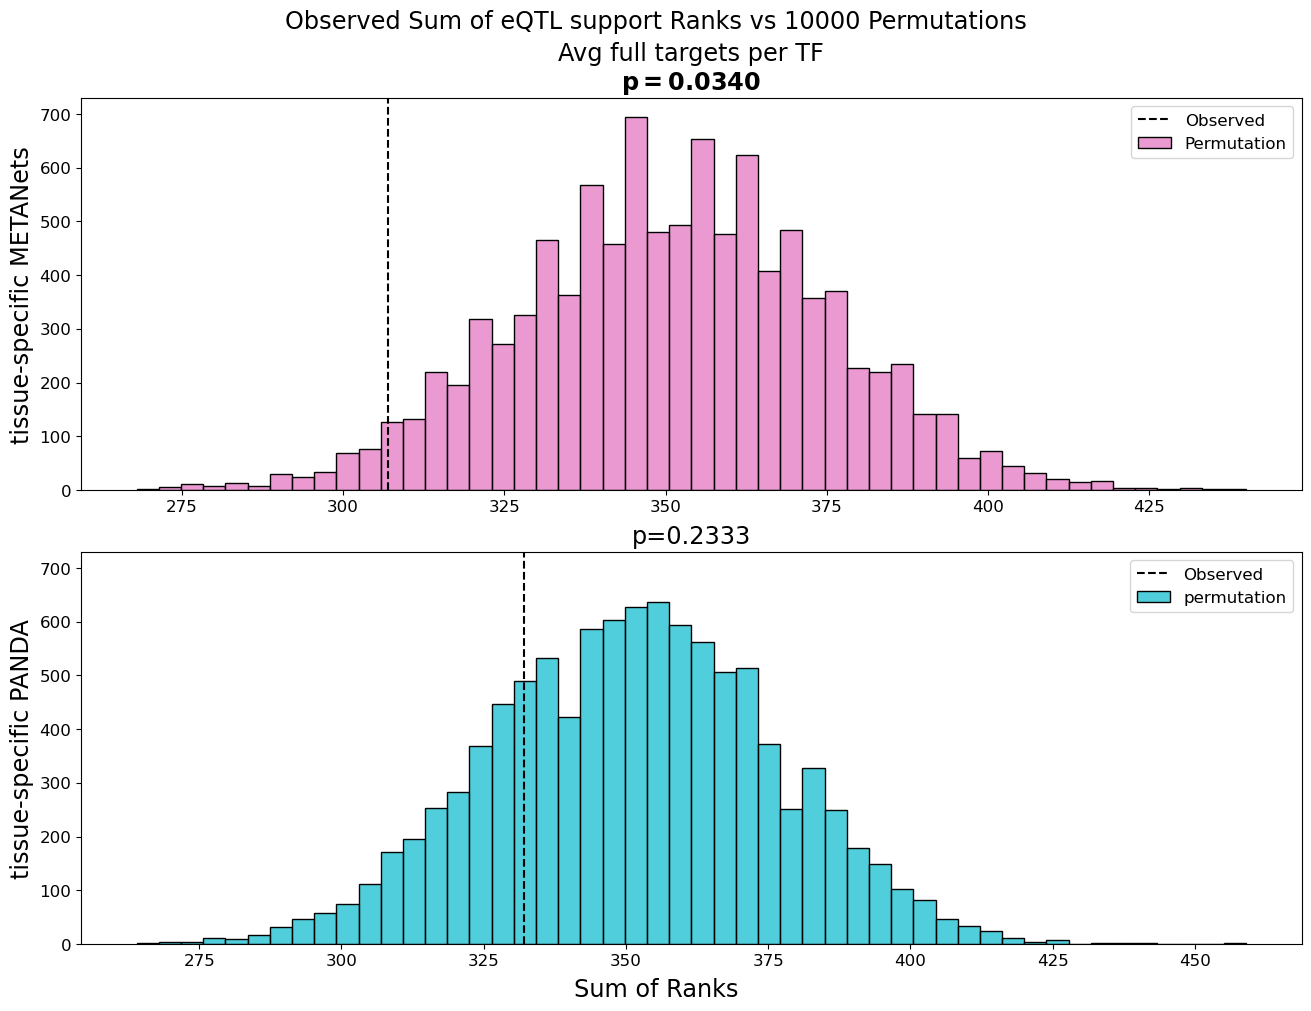

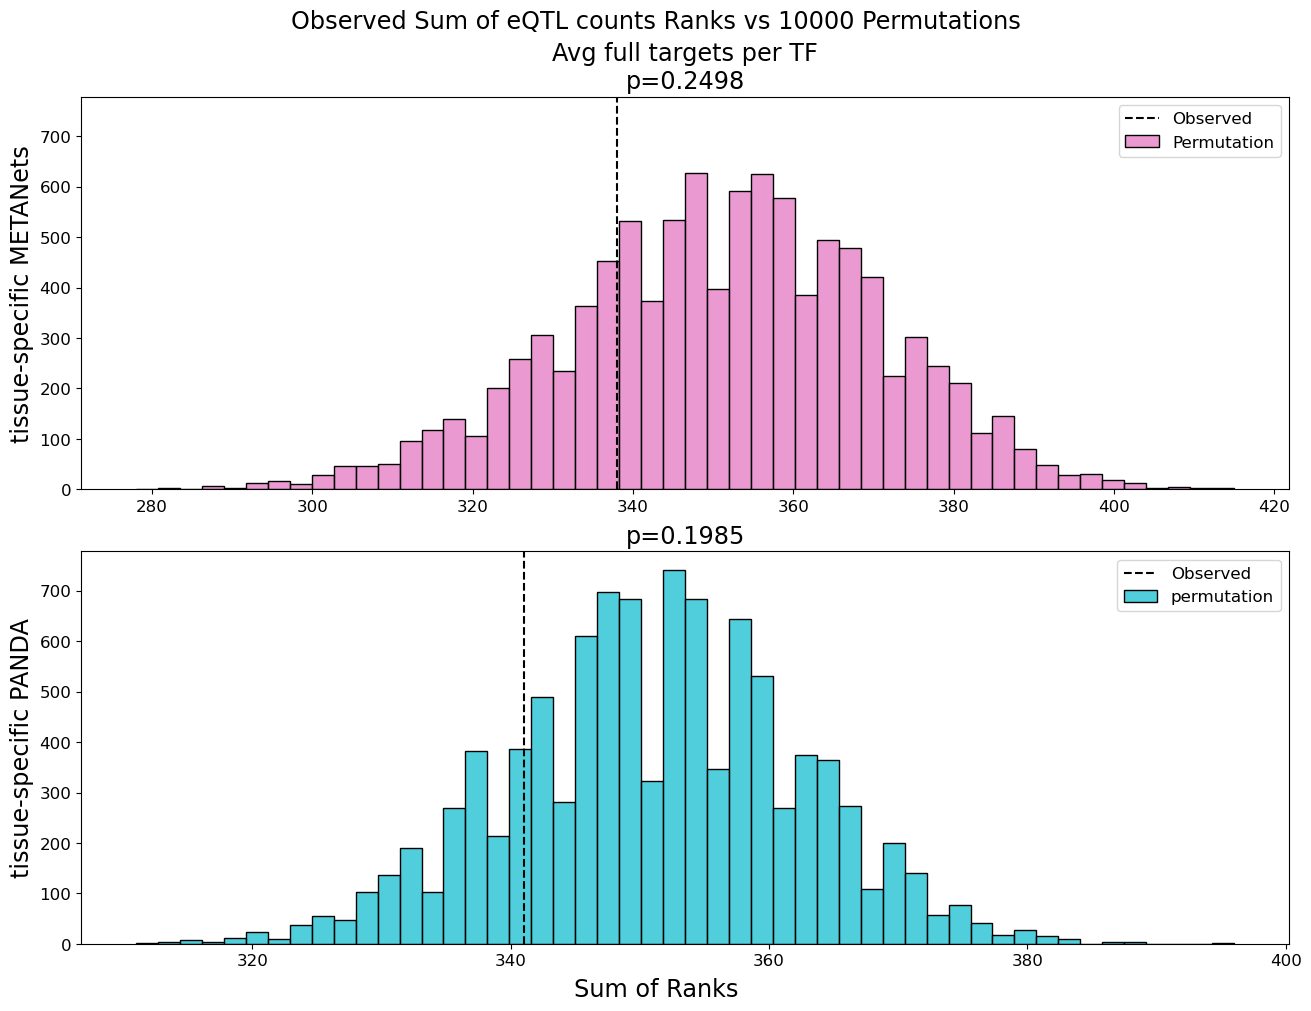

In [37]:
def plot_permutation(dict_final, dict_marbach, eqtl_metric='eQTL support'):
    fig, axes = plt.subplots(2,1, figsize=(13,10), sharey=True, sharex=False, constrained_layout=True)
    for i,threshold in enumerate(dict_final.keys()):
    
        ax_final = axes[0]
        ax_marbach = axes[1]
    
        obs_final, perm_final, p_final = dict_final[threshold][eqtl_metric]
        obs_marbach, perm_marbach, p_marbach = dict_marbach[threshold][eqtl_metric]

        assert len(perm_final) == len(perm_marbach)
        n_permutations = len(perm_final)
    
        sns.histplot(perm_final, bins=50, label='Permutation', color=model_palette['metanet_tissue_specific'], ax=ax_final)
        ax_final.axvline(obs_final, color='black', linestyle='--', lw=1.5, label='Observed')
        if i == 0:
            ax_final.legend()
        title = f"Avg {threshold} targets per TF\n"
        if p_final < 0.05:
            title = title + r"$\bf{{p={:.4f}}}$".format(p_final)
        else:
            title = title + "p={:.4f}".format(p_final)
            
        ax_final.set_title(title)
        ax_final.set_ylabel("tissue-specific METANets")
        
        sns.histplot(perm_marbach, bins=50, label='permutation', color=model_palette['panda_tissue_specific'], ax=ax_marbach)
        ax_marbach.axvline(obs_marbach, color='black', linestyle='--', lw=1.5, label='Observed')
        if i == 0:
            ax_marbach.legend()
        if p_marbach < 0.05:
            title = r"$\bf{{p={:.4f}}}$".format(p_marbach)
        else:
            title = "p={:.4f}".format(p_marbach)
        
        ax_marbach.set_title(title)
        ax_marbach.set_ylabel("tissue-specific PANDA")
    
    plt.suptitle(f"Observed Sum of {eqtl_metric} Ranks vs {n_permutations} Permutations")
    fig.supxlabel(f"Sum of Ranks")
    eqtl_metric_nospace = eqtl_metric.replace(' ', '_')
    plt.show()
    
plot_permutation(df_metanet_tissue_specific_permutation, df_panda_tissue_specific_permutation, eqtl_metric='eQTL support')
plot_permutation(df_metanet_tissue_specific_permutation, df_panda_tissue_specific_permutation, eqtl_metric='eQTL counts')


### (v) PLOT -- Tissue-specific METANet vs Tissue-specific PANDA

#### Wilcoxon Signed Rank Test

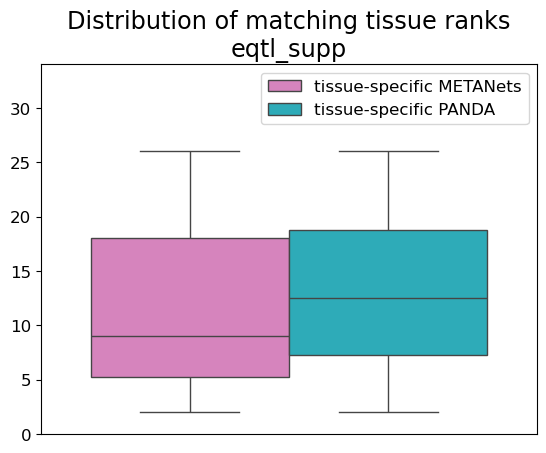

/ref/mblab/software/conda/envs/human_tf_project/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


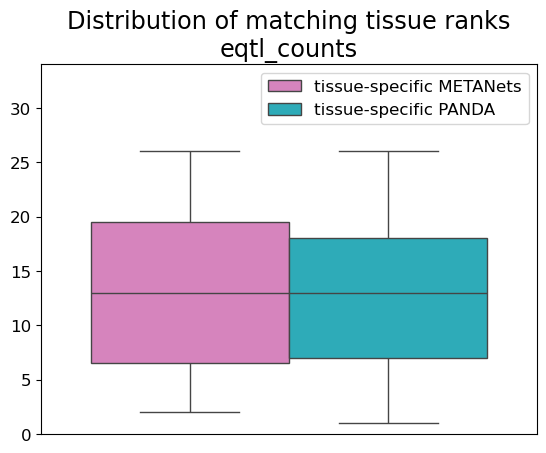

,Avg targets per TF,eQTL metric,Wilcoxon w,Wilcoxon p (two-sided)
0,full,eqtl_supp,125.0,0.474622
1,full,eqtl_counts,168.5,0.880922


In [38]:
from scipy.stats import wilcoxon
import itertools

def wilcoxon_test(df_final, df_marbach, threshold='full', eqtl_metric='eqtl_supp'):

    df_final = df_final[df_final['rank'] == threshold]
    df_marbach = df_marbach[df_marbach['rank'] == threshold]

    df_final = df_final[df_final['eqtl_tissue'] == df_final['network_tissue']]
    df_marbach = df_marbach[df_marbach['eqtl_tissue'] == df_marbach['network_tissue']]

    df_final = df_final.sort_values(by='eqtl_tissue')
    df_marbach = df_marbach.sort_values(by='eqtl_tissue')

    x = df_final[f'{eqtl_metric}_rank_break_ties']
    y = df_marbach[f'{eqtl_metric}_rank_break_ties']

    df_plot = pd.concat([df_final, df_marbach])
    sns.boxplot(df_plot, x='rank', y=f'{eqtl_metric}_rank_break_ties', hue='model', palette=model_palette)
    plt.title(f"Distribution of matching tissue ranks\n{eqtl_metric}")
    plt.ylim(0,34)
    plt.legend(loc=0)
    plt.ylabel(None)
    plt.xlabel(None)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False # labels along the bottom edge are off
    )
    plt.show()

    w, p_two =  wilcoxon(x,y, method='exact', alternative='two-sided')
    diff = np.array(x) - np.array(y)
    
    return w, p_two

w_list = []
p_two_list = []
rank_list = []
eqtl_list = []
for threshold, eqtl_metric in itertools.product(['full'], ['eqtl_supp','eqtl_counts']):
    w, p_two = wilcoxon_test(df_metanet_tissue_specific, df_panda_tissue_specific, threshold=threshold, eqtl_metric=eqtl_metric)
    rank_list.append(threshold)
    eqtl_list.append(eqtl_metric)
    w_list.append(w)
    p_two_list.append(p_two)
df_table = pd.DataFrame({'Avg targets per TF':rank_list, 'eQTL metric': eqtl_list, 'Wilcoxon w': w_list, 'Wilcoxon p (two-sided)':p_two_list})
df_table

In [39]:
df_table.pivot(columns='Avg targets per TF', index='eQTL metric', values='Wilcoxon w')

Avg targets per TF,full
eQTL metric,
eqtl_counts,168.5
eqtl_supp,125.0


In [40]:
df_table.pivot(columns='Avg targets per TF', index='eQTL metric', values='Wilcoxon p (two-sided)')

Avg targets per TF,full
eQTL metric,
eqtl_counts,0.880922
eqtl_supp,0.474622
